Type: Learning Project \
Author: Yash K
        
## About: ML project on Titanic dataset
Predict whether a person survived or not based on the training dataset

#### Preprocessing

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
#imports
import warnings
warnings.filterwarnings("ignore")

In [59]:
#read the train and test data
data_train = pd.read_csv('./titanic/train.csv')
data_test = pd.read_csv('./titanic/test.csv')

In [60]:
data_train.shape

(891, 12)

In [61]:
data_test.shape

(418, 11)

In [62]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Visualization

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

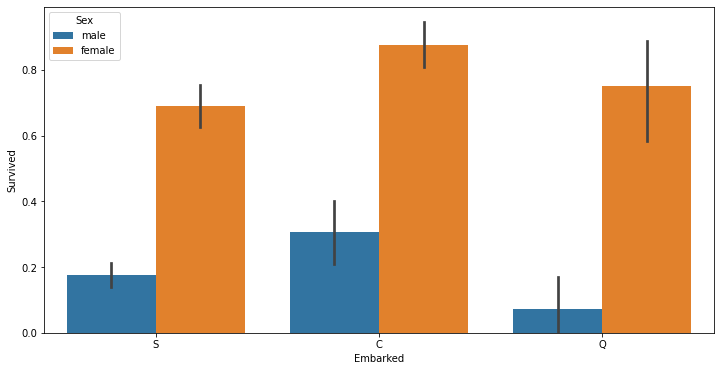

In [63]:
#vizualize survived as per gender 
plt.figure(figsize=(12,6))
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=data_train)

<AxesSubplot:xlabel='Fare', ylabel='Density'>

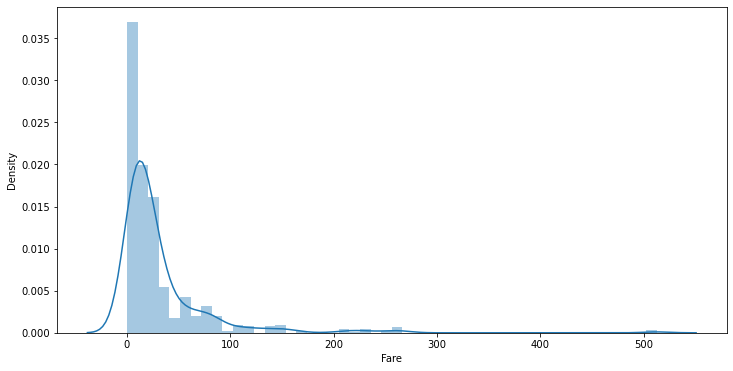

In [64]:
#See fare distribution for categorization
plt.figure(figsize=(12,6))
sns.distplot(data_train.Fare)

#### Data cleanup and transformation

In [65]:
#determine fare quartiles to determine fare bins
print ('1st quartile', np.quantile(data_train.Fare, 0.25))
print ('2nd quartile', np.quantile(data_train.Fare, 0.5))
print ('3rd quartile', np.quantile(data_train.Fare, 0.75))
print ('4th quartile', np.quantile(data_train.Fare, 1))

1st quartile 7.9104
2nd quartile 14.4542
3rd quartile 31.0
4th quartile 512.3292


In [66]:
def simplify_ages(df):
    #categorize ages, and make it a categorical variable
    df.Age = df.Age.fillna(-0.5) #fill missing data
    bins = (-1,0,5,12,18,25,35,60,120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories =pd.cut(df.Age, bins, labels=group_names) #pd.cut helps categorize continuous distributions
    df.Age=categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N') #fill missing data
    #get only the cabin letter
    df.Cabin = df.Cabin.apply(lambda x:x[0])
    return df

def simplify_fares(df):
    #categorize fares, and make it a categorical variable
    df.Fare = df.Fare.fillna(-0.5) #fill missing data
    bins = (-1, 0, 8, 15, 31, 1000) #determined using quarties from previous cell
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Last_name'] = df.Name.apply(lambda x:x.split(' ')[0].strip(','))
    df['Name_prefix'] = df.Name.apply(lambda x:x.split(' ')[1]) #Mr., Mrs., Miss etc.
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)
    
def transform_features(df):
    #put ages into brackets
    df = simplify_ages(df)
    #get cabins
    df = simplify_cabins(df)
    #simplify fares
    df = simplify_fares(df)
    #extract only last name and name prefix
    df = format_name(df)
    #drop unnecessary features
    df = drop_features(df)
    return df

In [67]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)

In [68]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Last_name,Name_prefix
0,1,0,3,male,Student,1,0,1_quartile,N,Braund,Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,Cumings,Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,Heikkinen,Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,Futrelle,Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,Allen,Mr.


#### Encode data

In [69]:
from sklearn import preprocessing

def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Last_name', 'Name_prefix']
    df_combined = pd.concat((df_train[features], df_test[features]), axis=0)
    
    for feature in features:
        le = preprocessing.LabelEncoder() #encodes data to numerical between 0 and n-1
        le.fit(df_combined[feature])
        df_train[feature]=le.transform(df_train[feature])
        df_test[feature]=le.transform(df_test[feature])
    return df_train, df_test

In [70]:
data_train, data_test = encode_features(data_train, data_test)

In [71]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Last_name,Name_prefix
0,1,0,3,1,4,1,0,0,7,99,19
1,2,1,1,0,0,1,0,3,2,181,20
2,3,1,3,0,7,0,0,0,7,328,16
3,4,1,1,0,7,1,0,3,2,266,20
4,5,0,3,1,7,0,0,1,7,15,19


#### Train test split

In [88]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

#split in 4:1 ratio 
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

#### Applying ML Algorithm

Using Logistic Regression Classifier

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

#model selection
model = LogisticRegression()

#choose some parameters to try
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
              'penalty': ['l1', 'l2','elasticnet']
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)


# Run the grid search -- searches the best parameters that fit the model
grid_obj = GridSearchCV(model, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
model = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
model.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [99]:
y_pred_test_lr=model.predict(X_test)
print('Accuracy with Logistic Regression:', accuracy_score(y_test, y_pred_test_lr)) #using logistic regression

Accuracy with Logistic Regression: 0.8044692737430168


Using Random Forest Classifier

In [98]:
from sklearn.ensemble import RandomForestClassifier

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=9)

In [101]:
y_pred_test_rf=clf.predict(X_test)
print('Accuracy with Logistic Regression:', accuracy_score(y_test, y_pred_test_rf)) #using random forests

Accuracy with Logistic Regression: 0.8212290502793296


Note: Better accuracy is observed with random forest classifier in this case

#### K-fold cross validation

In [110]:
from sklearn.model_selection import KFold

def run_KFold(clf):
    kf=KFold(n_splits=10)
    outcomes=[]
    fold=0
    for train_index, test_index in kf.split(X_all):
        fold+=10
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 
    
run_KFold(clf)

Fold 10 accuracy: 0.7666666666666667
Fold 20 accuracy: 0.8539325842696629
Fold 30 accuracy: 0.7865168539325843
Fold 40 accuracy: 0.8089887640449438
Fold 50 accuracy: 0.8426966292134831
Fold 60 accuracy: 0.8202247191011236
Fold 70 accuracy: 0.7640449438202247
Fold 80 accuracy: 0.8202247191011236
Fold 90 accuracy: 0.8764044943820225
Fold 100 accuracy: 0.8202247191011236
Mean Accuracy: 0.8159925093632958


#### Predict on test data

In [112]:
data_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Last_name,Name_prefix
0,892,3,1,7,0,0,0,7,399,19
1,893,3,0,0,1,0,0,7,841,20
2,894,2,1,3,0,0,1,7,550,19
3,895,3,1,7,0,0,1,7,849,19
4,896,3,0,4,1,1,1,7,341,20


In [113]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
